/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_67544/2044164412.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_rate', y='champion', data=top_10_win_rate, palette='viridis')
/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_67544/2044164412.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='side', y='result', data=side_stats, palette='coolwarm')
/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_67544/2044164412.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_rate', y='objective', dat

   side    result
0  Blue  0.525934
1   Red  0.474066


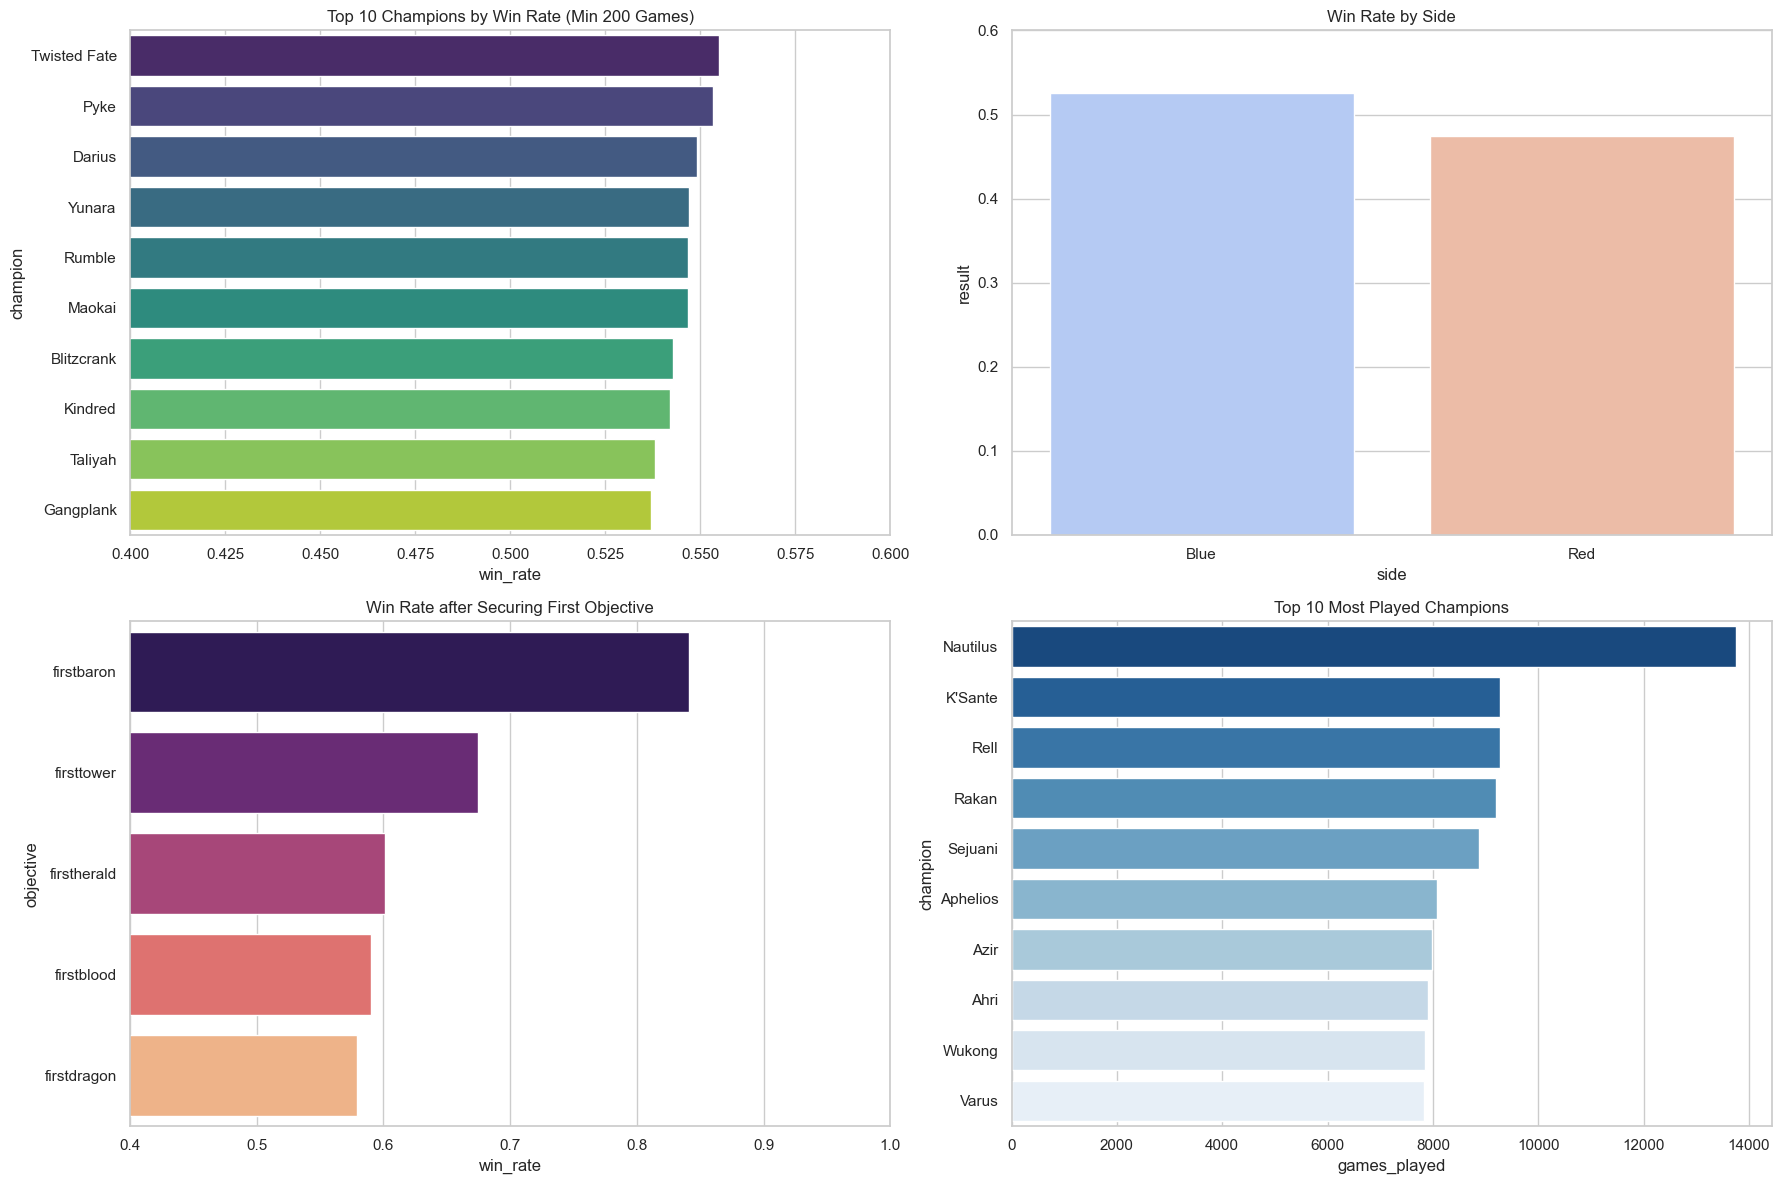

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data
game_result_df = pd.read_csv('../data_clean/game_result.csv')
realtime_df = pd.read_csv('../data_clean/realtime.csv')

# --- 1. Champion Win Rates & Popularity ---
# Combine Blue and Red team data into a single 'long' format
blue_cols = ['bot_blue', 'jng_blue', 'mid_blue', 'sup_blue', 'top_blue']
red_cols = ['bot_red', 'jng_red', 'mid_red', 'sup_red', 'top_red']

# Blue team wins if win=1, Red team wins if win=0
blue_melted = game_result_df[blue_cols + ['win']].melt(id_vars='win', value_vars=blue_cols, value_name='champion')
blue_melted['result'] = blue_melted['win']

red_melted = game_result_df[red_cols + ['win']].melt(id_vars='win', value_vars=red_cols, value_name='champion')
red_melted['result'] = 1 - red_melted['win'] # Inverse result for red team

all_champs = pd.concat([blue_melted[['champion', 'result']], red_melted[['champion', 'result']]])

# Calculate stats
champ_stats = all_champs.groupby('champion')['result'].agg(['count', 'mean']).reset_index()
champ_stats.columns = ['champion', 'games_played', 'win_rate']

# Filter for champions with enough data (> 200 games) to avoid outliers
filtered_champs = champ_stats[champ_stats['games_played'] > 200]
top_10_win_rate = filtered_champs.sort_values('win_rate', ascending=False).head(10)
top_10_played = filtered_champs.sort_values('games_played', ascending=False).head(10)

# --- 2. Side Win Rate ---
side_stats = realtime_df.groupby('side')['result'].mean().reset_index()

# --- 3. Objective Impact ---
objectives = ['firstblood', 'firstdragon', 'firsttower', 'firstbaron', 'firstherald']
objective_win_rates = []

for obj in objectives:
    # Calculate win rate when the team secures the specific objective
    win_rate = realtime_df[realtime_df[obj] == 1.0]['result'].mean()
    objective_win_rates.append({'objective': obj, 'win_rate': win_rate})

obj_df = pd.DataFrame(objective_win_rates)

# --- Plotting ---
plt.figure(figsize=(18, 12))

# Subplot 1: Top Win Rate Champions
plt.subplot(2, 2, 1)
sns.barplot(x='win_rate', y='champion', data=top_10_win_rate, palette='viridis')
plt.title('Top 10 Champions by Win Rate (Min 200 Games)')
plt.xlim(0.4, 0.6)

# Subplot 2: Side Win Rate
plt.subplot(2, 2, 2)
sns.barplot(x='side', y='result', data=side_stats, palette='coolwarm')
print(side_stats)
plt.title('Win Rate by Side')
plt.ylim(0, 0.6)

# Subplot 3: Objective Impact
plt.subplot(2, 2, 3)
sns.barplot(x='win_rate', y='objective', data=obj_df.sort_values('win_rate', ascending=False), palette='magma')
plt.title('Win Rate after Securing First Objective')
plt.xlim(0.4, 1.0)

# Subplot 4: Most Played Champions
plt.subplot(2, 2, 4)
sns.barplot(x='games_played', y='champion', data=top_10_played, palette='Blues_r')
plt.title('Top 10 Most Played Champions')

plt.tight_layout()
plt.show()

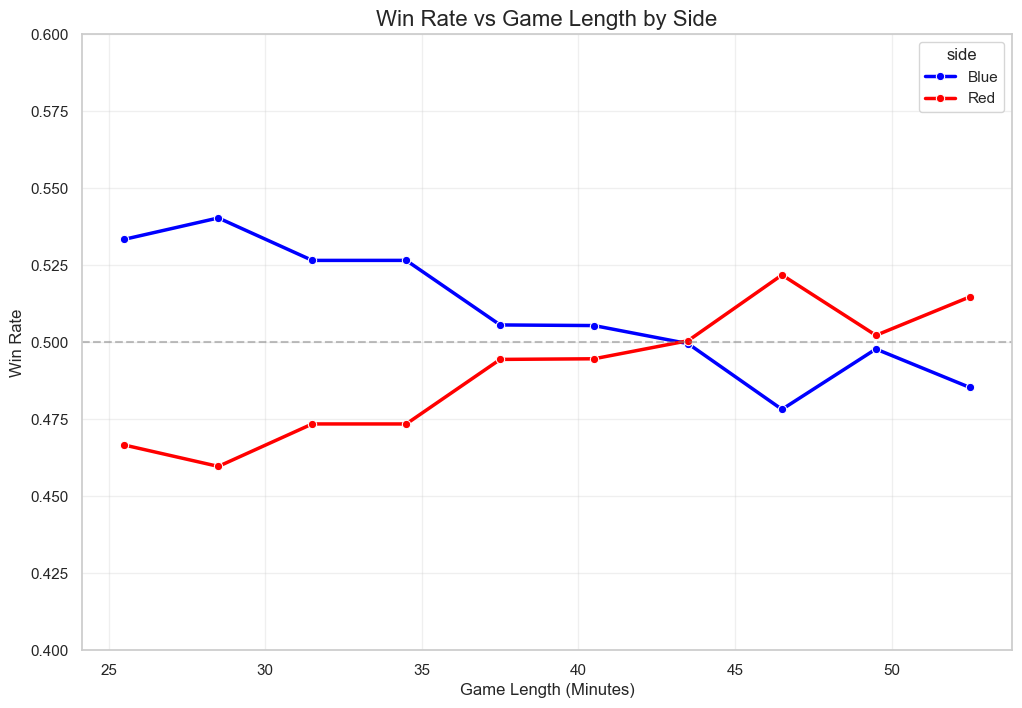

In [5]:

# Convert gamelength to minutes
realtime_df['gamelength_min'] = realtime_df['gamelength'] / 60

# Define 3-minute bins from 15 to 60 minutes
bins = np.arange(15, 61, 3)
labels = (bins[:-1] + bins[1:]) / 2

# Create bins
realtime_df['time_bin'] = pd.cut(realtime_df['gamelength_min'], bins=bins, labels=labels)

# Group by Side and Time Bin
agg = realtime_df.groupby(['side', 'time_bin'])['result'].agg(['mean', 'count']).reset_index()

# Filter out bins with insufficient data
agg = agg[agg['count'] >= 50]
agg['time_bin'] = agg['time_bin'].astype(float)

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    x='time_bin', 
    y='mean', 
    hue='side', 
    data=agg, 
    palette={'Blue': 'blue', 'Red': 'red'}, 
    marker='o', 
    linewidth=2.5
)

plt.title('Win Rate vs Game Length by Side', fontsize=16)
plt.xlabel('Game Length (Minutes)', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
# Limit Y-axis to relevant range to see the crossover clearly
plt.ylim(0.4, 0.6) 

plt.show()

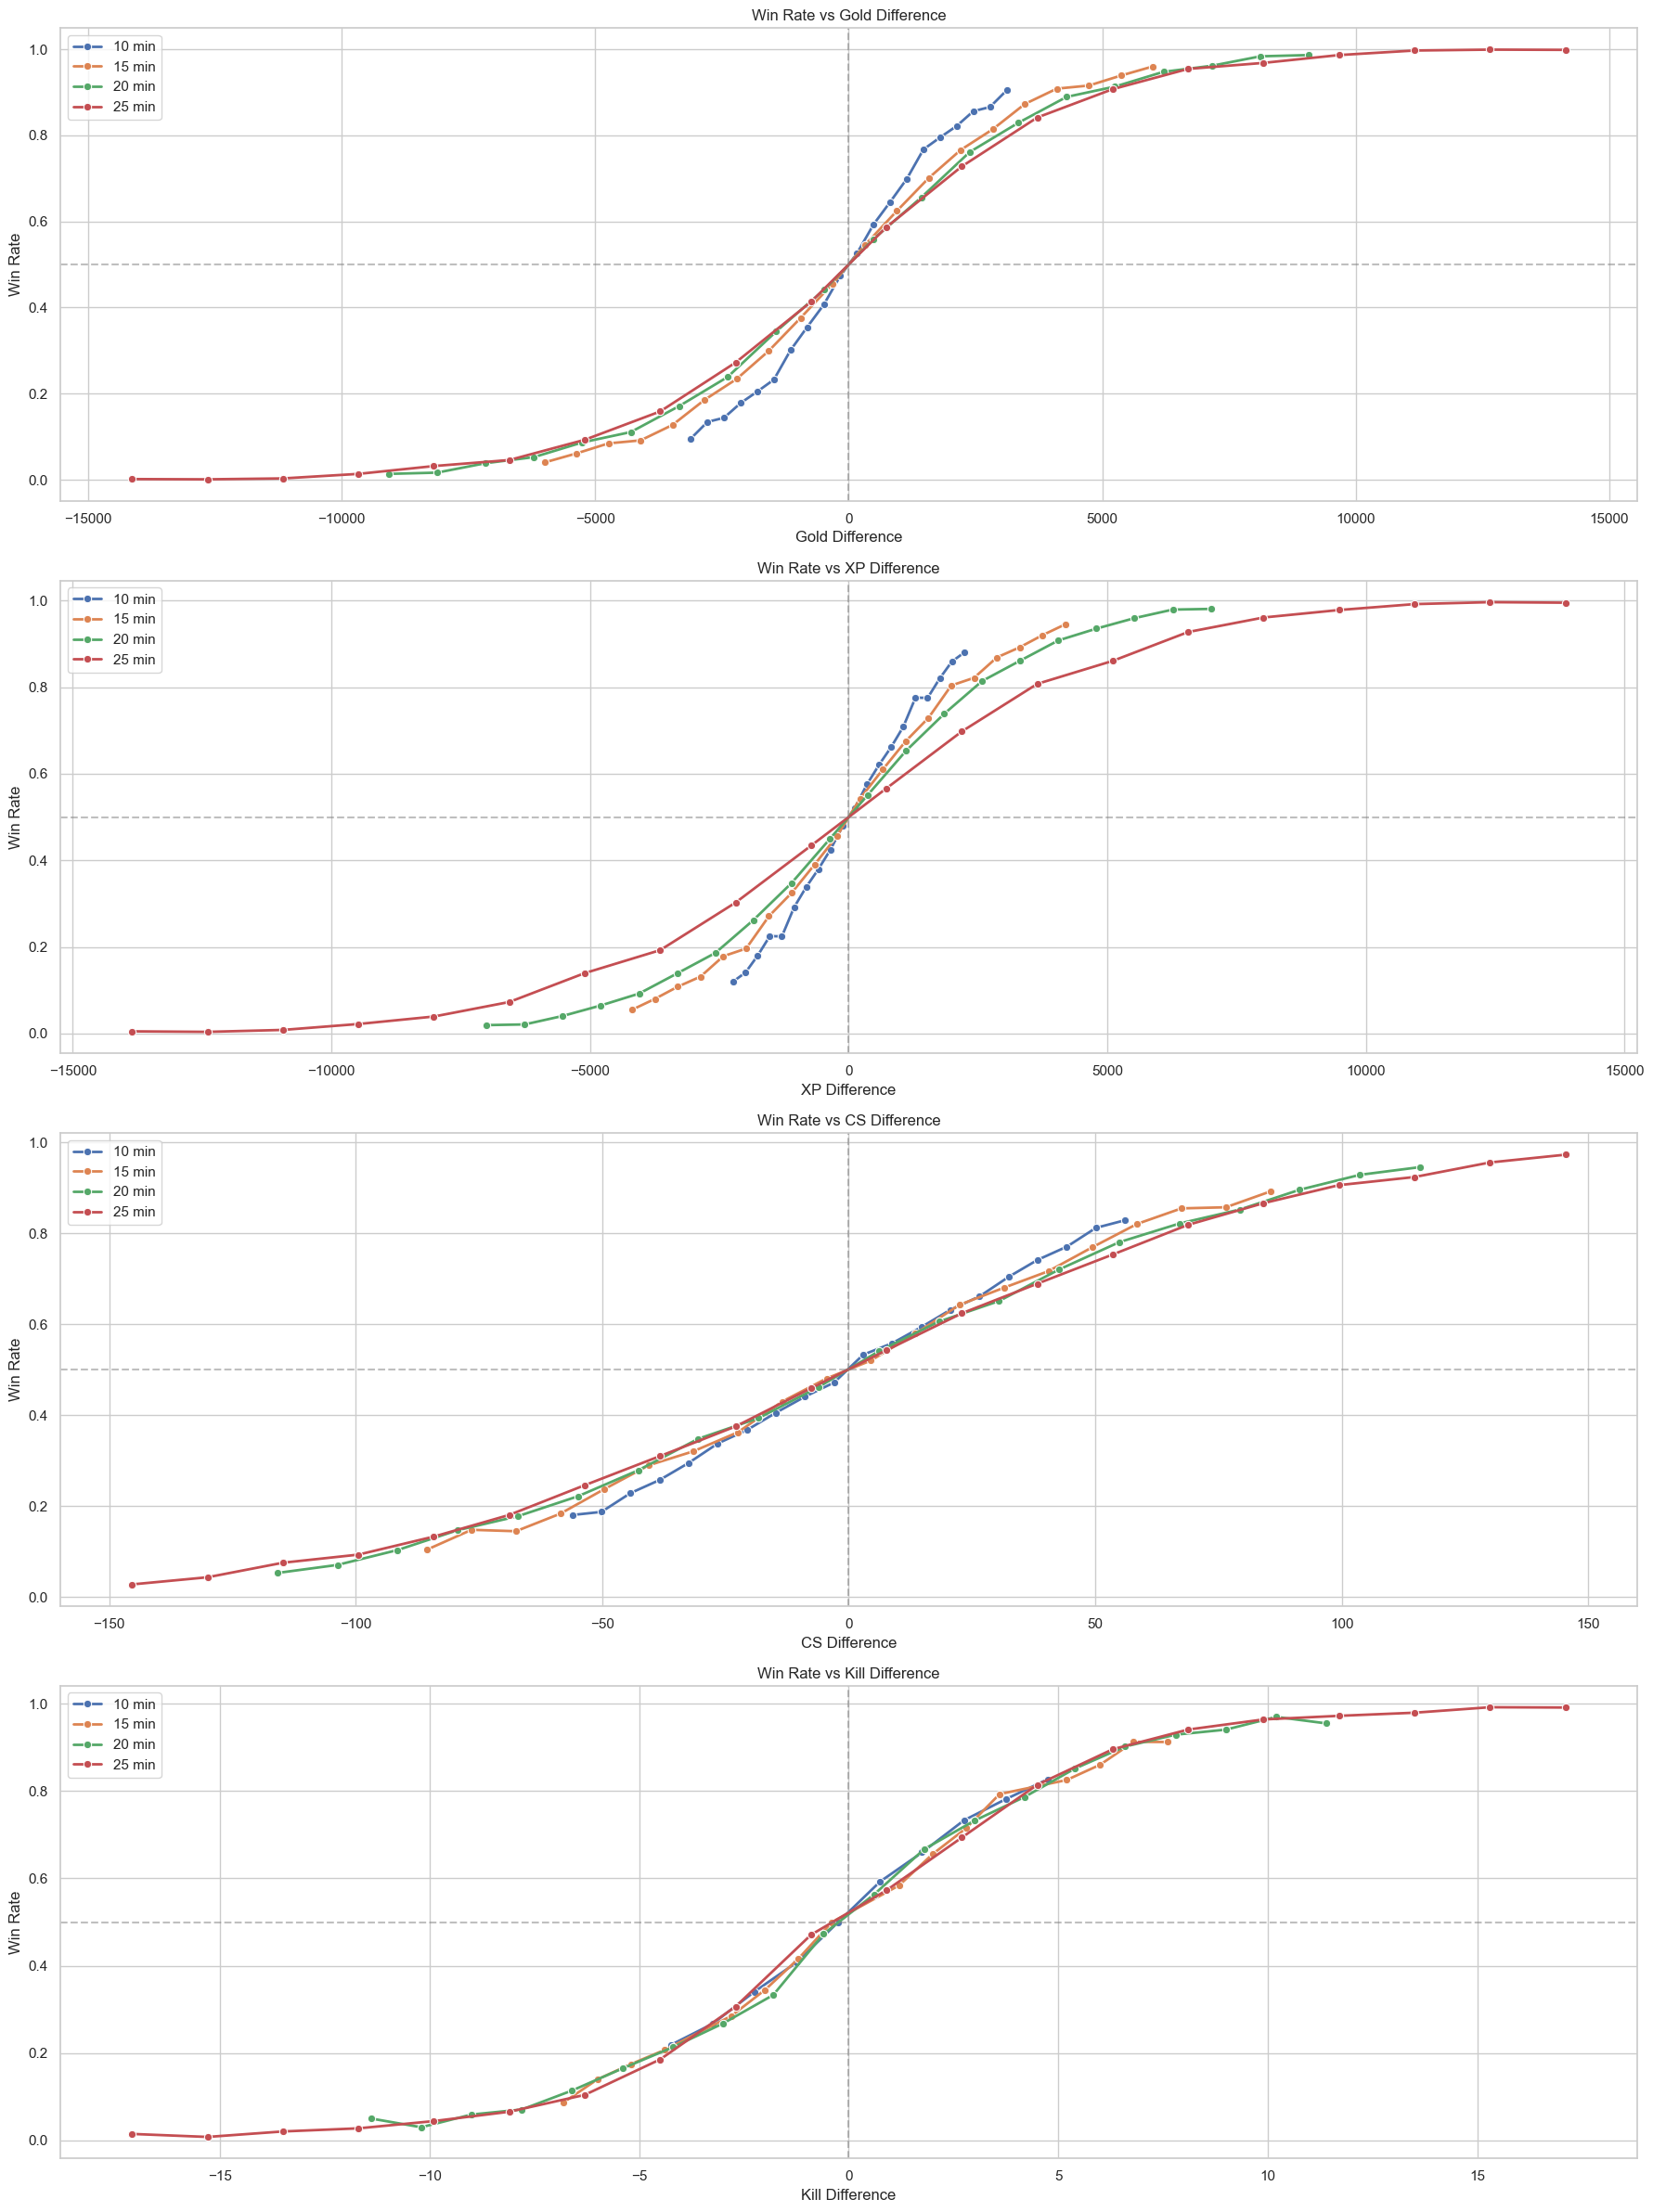

In [6]:
sns.set(style="whitegrid")

# -------------------------------------------------------------------
# Helper: make sure gamelength_min exists
# -------------------------------------------------------------------
if 'gamelength_min' not in realtime_df.columns:
    # Convert game length from seconds to minutes if not already present
    realtime_df['gamelength_min'] = realtime_df['gamelength'] / 60.0


# ===================================================================
# 1) Win rate vs multi-metric difference (Gold / XP / CS / Kills)
#    (team-level, for multiple time points)
# ===================================================================
time_points = [10, 15, 20, 25]
for t in time_points:
    # Kills Diff = Team Kills - Opponent Kills
    realtime_df[f'killsdiffat{t}'] = realtime_df[f'killsat{t}'] - realtime_df[f'opp_killsat{t}']

def plot1_multi_metric_diff_vs_winrate(df, min_games=50):
    """
    Plot win rate against diff metrics (gold/xp/cs/kills) at 10/15/20/25 minutes.
    Each subplot is one metric; each line is a different time point.
    """
    metrics = {
        'golddiffat': 'Gold Difference',
        'xpdiffat': 'XP Difference',
        'csdiffat': 'CS Difference',
        'killsdiffat': 'Kill Difference',
    }
    time_points = [10, 15, 20, 25]

    fig, axes = plt.subplots(4, 1, figsize=(18, 24))
    axes = axes.flatten()

    for ax, (prefix, label) in zip(axes, metrics.items()):
        for t in time_points:
            col = f'{prefix}{t}'
            if col not in df.columns:
                # Skip if the column does not exist in the CSV
                continue

            tmp = df[[col, 'result']].copy().dropna()
            if tmp.empty:
                continue

            # Create bins based on percentile range to avoid extreme outliers
            low, high = np.percentile(tmp[col], [1, 99])
            bins = np.linspace(low, high, 21)
            tmp['bin'] = pd.cut(tmp[col], bins=bins)

            agg = tmp.groupby('bin')['result'].agg(['mean', 'count']).reset_index()
            agg = agg[agg['count'] >= min_games]
            if agg.empty:
                continue

            # Use bin midpoints as x-axis
            agg['bin_center'] = agg['bin'].apply(lambda x: x.mid)

            sns.lineplot(
                x='bin_center',
                y='mean',
                data=agg,
                marker='o',
                linewidth=2,
                label=f'{t} min',
                ax=ax
            )

        ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(0.0, color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f'Win Rate vs {label}')
        ax.set_xlabel(label)
        ax.set_ylabel('Win Rate')
        ax.legend()

    plt.tight_layout()
    plt.show()
plot1_multi_metric_diff_vs_winrate(realtime_df, min_games=50)


/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_67544/2454195811.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='win_rate', y='duo', palette='viridis')


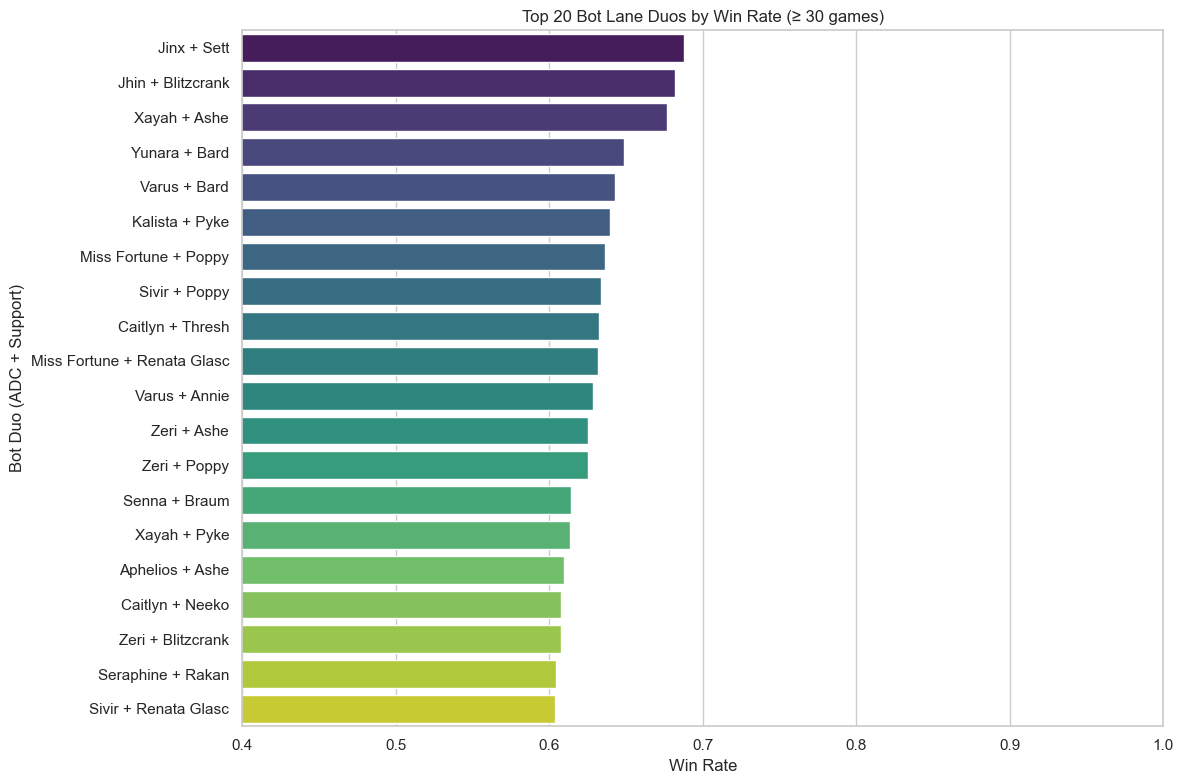

In [7]:
# ===================================================================
# 2) Bot lane synergy: ADC + Support duo win rate
# ===================================================================
def compute_bot_duo_stats(game_result_df, min_games=30):
    """
    Compute win rate per bot lane duo (ADC + Support) across both sides.
    """
    # Blue side bot lane
    blue = game_result_df[['bot_blue', 'sup_blue', 'win']].copy()
    blue['duo'] = blue['bot_blue'] + ' + ' + blue['sup_blue']
    blue['result'] = blue['win']  # win is from Blue perspective

    # Red side bot lane
    red = game_result_df[['bot_red', 'sup_red', 'win']].copy()
    red['duo'] = red['bot_red'] + ' + ' + red['sup_red']
    red['result'] = 1 - red['win']  # invert, since win=0 means Red side won

    all_duos = pd.concat([blue[['duo', 'result']], red[['duo', 'result']]], ignore_index=True)

    stats = all_duos.groupby('duo')['result'].agg(['count', 'mean']).reset_index()
    stats.columns = ['duo', 'games_played', 'win_rate']
    stats = stats[stats['games_played'] >= min_games]
    return stats


def plot2_bot_duo_synergy(game_result_df, min_games=30, top_n=20):
    """
    Plot top-N bot lane duos by win rate (ADC + Support).
    """
    stats = compute_bot_duo_stats(game_result_df, min_games=min_games)
    if stats.empty:
        print("No bot duos meet the minimum game threshold.")
        return

    top = stats.sort_values('win_rate', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top, x='win_rate', y='duo', palette='viridis')
    plt.title(f'Top {top_n} Bot Lane Duos by Win Rate (≥ {min_games} games)')
    plt.xlabel('Win Rate')
    plt.ylabel('Bot Duo (ADC + Support)')
    plt.xlim(0.4, 1.0)
    plt.tight_layout()
    plt.show()
plot2_bot_duo_synergy(game_result_df, min_games=30, top_n=20)

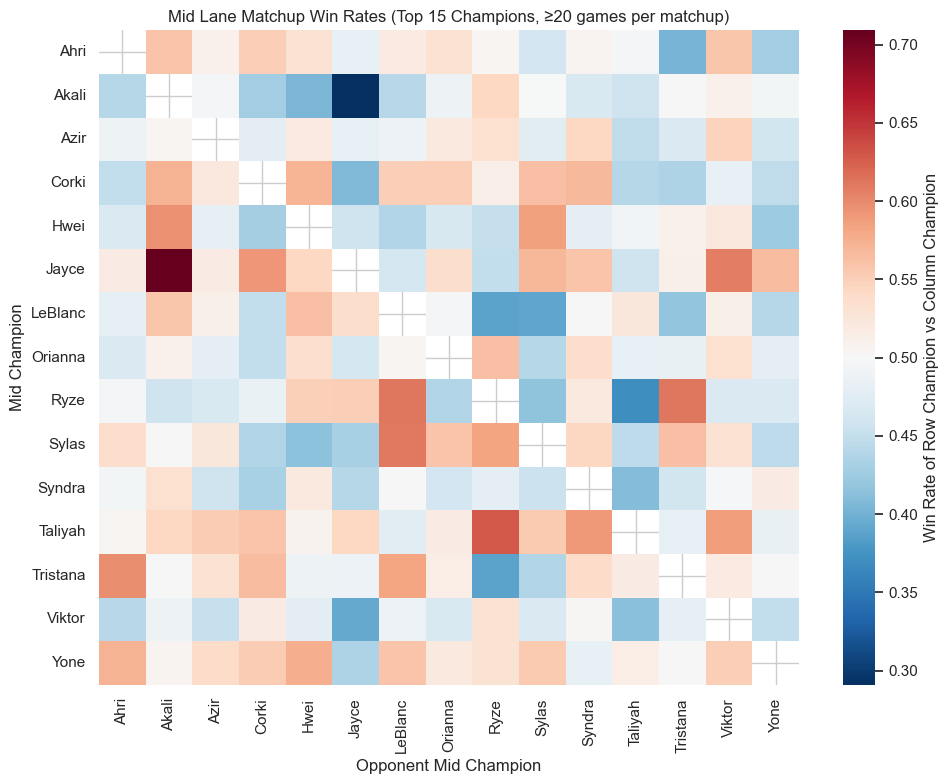

In [8]:
# ===================================================================
# 3) Mid lane matchup heatmap (champ vs champ win rate)
# ===================================================================
def plot3_mid_matchup_heatmap(game_result_df, min_games=20, top_n=15):
    """
    Create a heatmap of mid-lane champion vs champion win rates.
    Rows: champion A, Columns: champion B, Value: win rate of A vs B.
    Only top-N most common champions are shown.
    """
    df = game_result_df[['mid_blue', 'mid_red', 'win']].dropna()

    records = []
    for _, row in df.iterrows():
        mid_blue = row['mid_blue']
        mid_red = row['mid_red']
        win_blue = row['win']  # 1 if blue wins, 0 if red wins

        # Perspective: champion A = mid_blue
        records.append({
            'champA': mid_blue,
            'champB': mid_red,
            'result': 1 if win_blue == 1 else 0   # 1 if champA (blue mid) wins
        })

        # Perspective: champion A = mid_red
        records.append({
            'champA': mid_red,
            'champB': mid_blue,
            'result': 1 if win_blue == 0 else 0   # 1 if champA (red mid) wins
        })

    matchup_df = pd.DataFrame(records)

    # Aggregate win rate and counts
    agg = matchup_df.groupby(['champA', 'champB'])['result'].agg(['mean', 'count']).reset_index()
    agg = agg[agg['count'] >= min_games]

    if agg.empty:
        print("Not enough mid matchups after filtering by minimum games.")
        return

    # Choose top-N champions by total matchup counts
    champ_counts = agg.groupby('champA')['count'].sum().sort_values(ascending=False)
    top_champs = champ_counts.head(top_n).index

    filtered = agg[agg['champA'].isin(top_champs) & agg['champB'].isin(top_champs)]
    if filtered.empty:
        print("Filtered champion pairs are empty after limiting to top champions.")
        return

    pivot = filtered.pivot(index='champA', columns='champB', values='mean')

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pivot,
        cmap='RdBu_r',
        center=0.5,
        annot=False,
        cbar_kws={'label': 'Win Rate of Row Champion vs Column Champion'}
    )
    plt.title(f'Mid Lane Matchup Win Rates (Top {top_n} Champions, ≥{min_games} games per matchup)')
    plt.xlabel('Opponent Mid Champion')
    plt.ylabel('Mid Champion')
    plt.tight_layout()
    plt.show()
plot3_mid_matchup_heatmap(game_result_df, min_games=20, top_n=15)

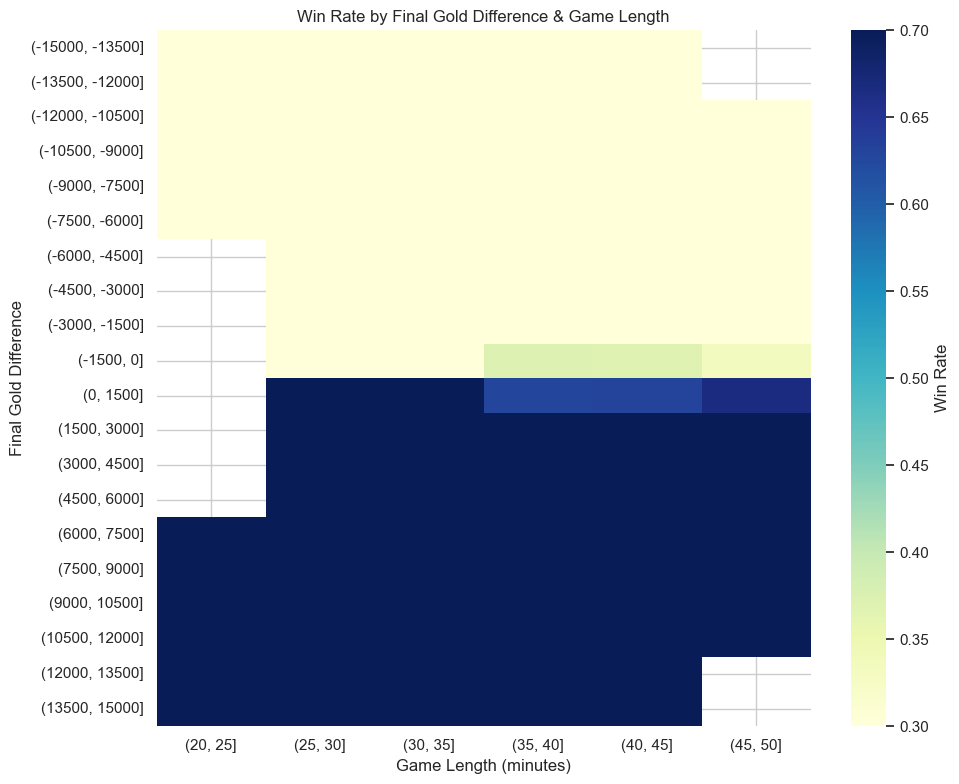

In [9]:
# ===================================================================
# 4) 2D heatmap: final gold diff vs game length vs win rate
# ===================================================================
def plot4_time_golddiff_heatmap(df, min_games=30):
    """
    2D heatmap: game length (minutes) vs final gold difference, colored by win rate.
    Uses final totalgold vs opponent's totalgold.
    """
    # Build a helper DataFrame with opponent total gold
    gold_df = df[['gameid', 'side', 'totalgold', 'gamelength_min', 'result']].copy()

    # Create opponent rows by swapping side
    opp = gold_df[['gameid', 'side', 'totalgold']].copy()
    opp['side'] = opp['side'].map({'Blue': 'Red', 'Red': 'Blue'})
    opp = opp.rename(columns={'totalgold': 'opp_totalgold'})

    merged = gold_df.merge(opp, on=['gameid', 'side'], how='left')
    merged['final_golddiff'] = merged['totalgold'] - merged['opp_totalgold']

    # Define bins for time and gold diff
    time_bins = np.arange(15, 51, 5)  # 15 to 50 minutes
    gold_bins = np.arange(-15000, 15001, 1500)

    merged['time_bin'] = pd.cut(merged['gamelength_min'], bins=time_bins)
    merged['gold_bin'] = pd.cut(merged['final_golddiff'], bins=gold_bins)

    agg = merged.groupby(['time_bin', 'gold_bin'])['result'].agg(['mean', 'count']).reset_index()
    agg = agg[agg['count'] >= min_games]

    if agg.empty:
        print("Not enough data for the chosen bins and minimum games.")
        return

    # Pivot to 2D matrix
    heatmap_data = agg.pivot(index='gold_bin', columns='time_bin', values='mean')

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data,
        cmap='YlGnBu',
        vmin=0.3,
        vmax=0.7,
        cbar_kws={'label': 'Win Rate'}
    )
    plt.title('Win Rate by Final Gold Difference & Game Length')
    plt.xlabel('Game Length (minutes)')
    plt.ylabel('Final Gold Difference')
    plt.tight_layout()
    plt.show()
plot4_time_golddiff_heatmap(realtime_df, min_games=30)

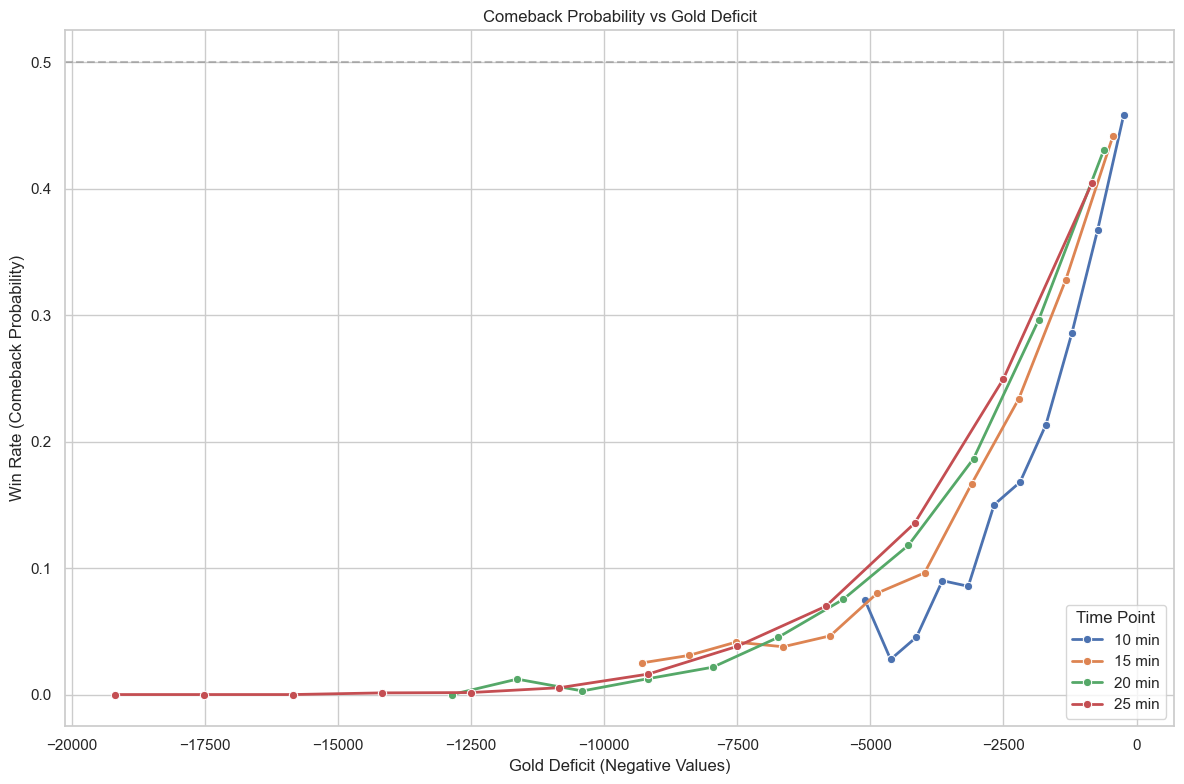

In [10]:

# ===================================================================
# 5) Comeback probability: win rate given negative gold deficit
# ===================================================================
def plot5_comeback_probability(df, time_points=[10, 15, 20, 25], min_games=30):
    """
    Plot comeback probability (win rate) for teams that are behind in gold
    at 10/15/20/25 minutes.
    Only negative gold differences are considered.
    """
    plt.figure(figsize=(12, 8))

    for t in time_points:
        col = f'golddiffat{t}'
        if col not in df.columns:
            continue

        tmp = df[[col, 'result']].copy().dropna()
        # Only consider teams that are behind (negative gold difference)
        tmp = tmp[tmp[col] < 0]

        if tmp.empty:
            continue

        # Create bins from min deficit to -1
        bins = np.linspace(tmp[col].min(), -1, 15)
        tmp['bin'] = pd.cut(tmp[col], bins=bins)

        agg = tmp.groupby('bin')['result'].agg(['mean', 'count']).reset_index()
        agg = agg[agg['count'] >= min_games]
        if agg.empty:
            continue

        agg['bin_center'] = agg['bin'].apply(lambda x: x.mid)

        sns.lineplot(
            x='bin_center',
            y='mean',
            data=agg,
            marker='o',
            linewidth=2,
            label=f'{t} min'
        )

    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.title('Comeback Probability vs Gold Deficit')
    plt.xlabel('Gold Deficit (Negative Values)')
    plt.ylabel('Win Rate (Comeback Probability)')
    plt.legend(title='Time Point')
    plt.tight_layout()
    plt.show()
plot5_comeback_probability(realtime_df, time_points=[10, 15, 20, 25], min_games=30)

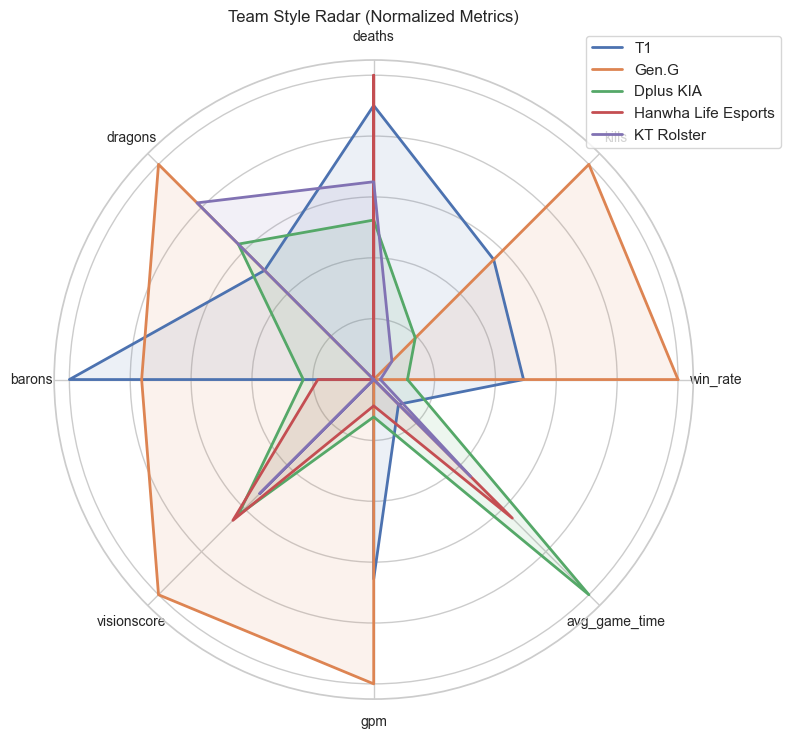

In [11]:
# ===================================================================
# 6) Team radar chart: style / strength profile per team
# ===================================================================
def plot6_team_radar(df, top_n_teams=5):
    """
    Radar chart for top teams (by number of games).
    Metrics include win rate, kills, deaths, game length, dragons, barons, vision, gold.
    """
    # Aggregate metrics per team
    team_stats = df.groupby('teamname').agg({
        'result': 'mean',          # win rate
        'kills': 'mean',
        'deaths': 'mean',
        'dragons': 'mean',
        'barons': 'mean',
        'visionscore': 'mean',
        'earned_gpm': 'mean',
        'gamelength_min': 'mean'
    }).rename(columns={
        'result': 'win_rate',
        'earned_gpm': 'gpm',
        'gamelength_min': 'avg_game_time'
    })

    # Keep only teams with enough games
    game_counts = df['teamname'].value_counts()
    top_teams = game_counts.head(top_n_teams).index
    team_stats = team_stats.loc[top_teams]

    if team_stats.empty:
        print("No team stats available for radar chart.")
        return

    # Normalize metrics to [0, 1] for radar plotting
    metrics = ['win_rate', 'kills', 'deaths', 'dragons', 'barons', 'visionscore', 'gpm', 'avg_game_time']
    norm_stats = (team_stats[metrics] - team_stats[metrics].min()) / (team_stats[metrics].max() - team_stats[metrics].min() + 1e-6)

    # Radar setup
    categories = metrics
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for team_name, row in norm_stats.iterrows():
        values = row.values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=team_name)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticklabels([])  # Hide radial labels
    plt.title('Team Style Radar (Normalized Metrics)')
    plt.legend(bbox_to_anchor=(1.15, 1.05))
    plt.tight_layout()
    plt.show()
plot6_team_radar(realtime_df, top_n_teams=5)

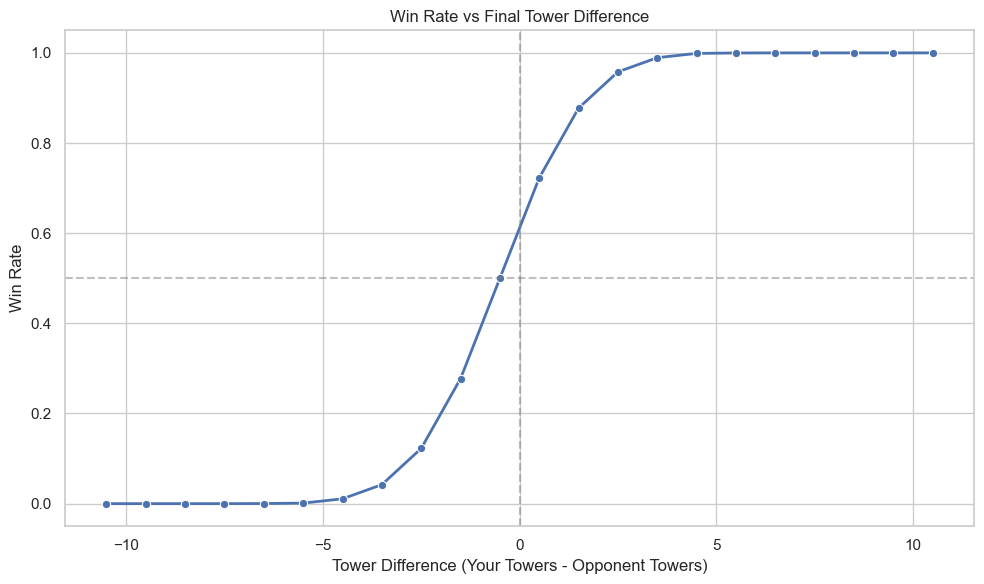

In [22]:
# ===================================================================
# 7) Tower difference vs win rate
# ===================================================================
def plot7_tower_diff_vs_winrate(df, min_games=30):
    """
    Plot win rate as a function of final tower difference (towers - opp_towers).
    """
    df = df.copy()
    df['tower_diff'] = df['towers'] - df['opp_towers']

    bins = np.arange(-11, 12, 1)
    df['bin'] = pd.cut(df['tower_diff'], bins=bins)

    agg = df.groupby('bin')['result'].agg(['mean', 'count']).reset_index()
    agg = agg[agg['count'] >= min_games]
    if agg.empty:
        print("Not enough data for tower difference bins.")
        return

    agg['bin_center'] = agg['bin'].apply(lambda x: x.mid)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='bin_center', y='mean', data=agg, marker='o', linewidth=2)
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Win Rate vs Final Tower Difference')
    plt.xlabel('Tower Difference (Your Towers - Opponent Towers)')
    plt.ylabel('Win Rate')
    plt.tight_layout()
    plt.show()
plot7_tower_diff_vs_winrate(realtime_df, min_games=30)

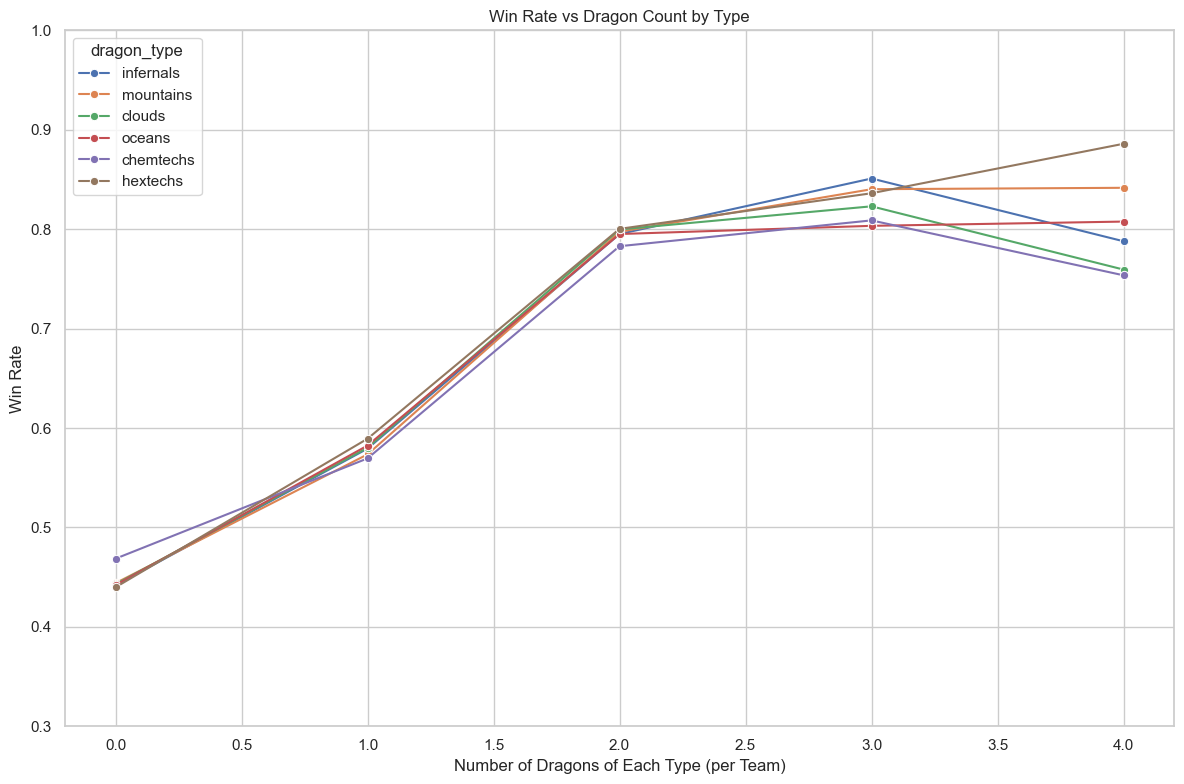

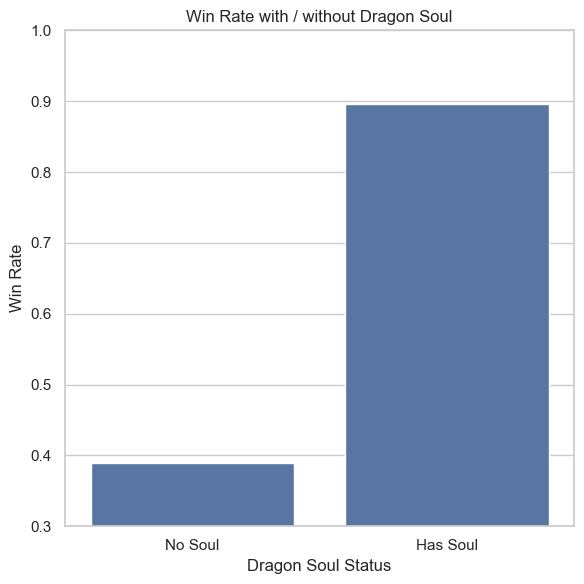

In [13]:
# ===================================================================
# 8) Dragon types & soul vs win rate
# ===================================================================
def plot8_dragon_types_vs_winrate(df):
    """
    Analyze how the number of each elemental dragon and having a soul
    relate to win rate.
    """
    # Dragon type columns (adjust if your CSV uses slightly different names)
    dragon_types = ['infernals', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs']
    available_types = [d for d in dragon_types if d in df.columns]

    rows = []
    for d in available_types:
        # Bin by number of that specific dragon
        tmp = df[[d, 'result']].copy().dropna()
        tmp[d] = tmp[d].astype(int)
        for n in sorted(tmp[d].unique()):
            sub = tmp[tmp[d] == n]
            rows.append({
                'dragon_type': d,
                'count': n,
                'games': len(sub),
                'win_rate': sub['result'].mean()
            })

    dragon_stats = pd.DataFrame(rows)
    dragon_stats = dragon_stats[dragon_stats['games'] >= 20]

    # Plot per dragon type, number vs win rate
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=dragon_stats,
        x='count',
        y='win_rate',
        hue='dragon_type',
        marker='o'
    )
    plt.title('Win Rate vs Dragon Count by Type')
    plt.xlabel('Number of Dragons of Each Type (per Team)')
    plt.ylabel('Win Rate')
    plt.ylim(0.3, 1.0)
    plt.tight_layout()
    plt.show()

    # Dragon soul effect (approximate: elementaldrakes >= 4)
    if 'elementaldrakes' in df.columns:
        soul_df = df.copy()
        soul_df['has_soul'] = soul_df['elementaldrakes'] >= 4
        soul_stats = soul_df.groupby('has_soul')['result'].mean().reset_index()

        plt.figure(figsize=(6, 6))
        sns.barplot(x='has_soul', y='result', data=soul_stats)
        plt.xticks([0, 1], ['No Soul', 'Has Soul'])
        plt.title('Win Rate with / without Dragon Soul')
        plt.ylabel('Win Rate')
        plt.xlabel('Dragon Soul Status')
        plt.ylim(0.3, 1.0)
        plt.tight_layout()
        plt.show()
plot8_dragon_types_vs_winrate(realtime_df)

/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_67544/3641122265.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='firstbaron', data=first_obj_stats, ax=axes[0], palette='viridis')
/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_67544/3641122265.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='heralds', y='secured_baron', data=herald_count_stats, ax=axes[1], palette='magma')


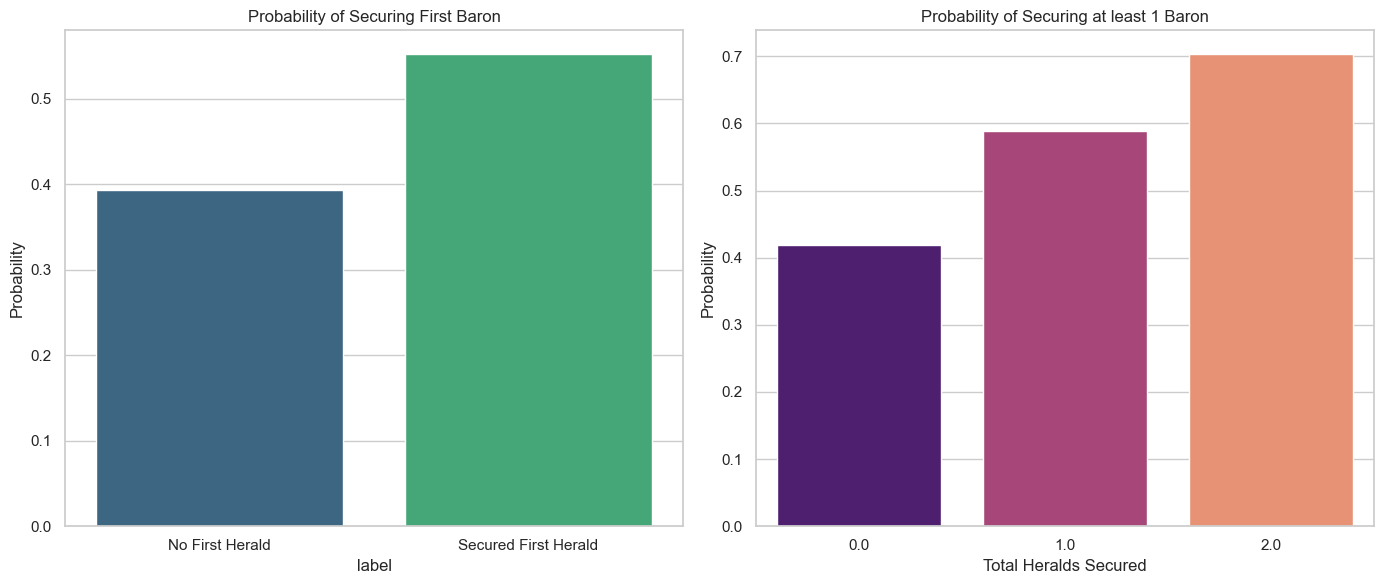

In [19]:


# --- Analysis 1: First Herald -> First Baron ---
# Calculate P(First Baron | First Herald)
first_obj_stats = realtime_df.groupby('firstherald')['firstbaron'].mean().reset_index()
first_obj_stats['label'] = first_obj_stats['firstherald'].map({0: 'No First Herald', 1: 'Secured First Herald'})

# --- Analysis 2: Total Heralds -> Any Baron ---
# Calculate P(Barons > 0 | Total Heralds)
realtime_df['secured_baron'] = (realtime_df['barons'] > 0).astype(int)
herald_count_stats = realtime_df.groupby('heralds')['secured_baron'].mean().reset_index()

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1
sns.barplot(x='label', y='firstbaron', data=first_obj_stats, ax=axes[0], palette='viridis')
axes[0].set_title('Probability of Securing First Baron')
axes[0].set_ylabel('Probability')

# Plot 2
sns.barplot(x='heralds', y='secured_baron', data=herald_count_stats, ax=axes[1], palette='magma')
axes[1].set_title('Probability of Securing at least 1 Baron')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Total Heralds Secured')

plt.tight_layout()
plt.show()

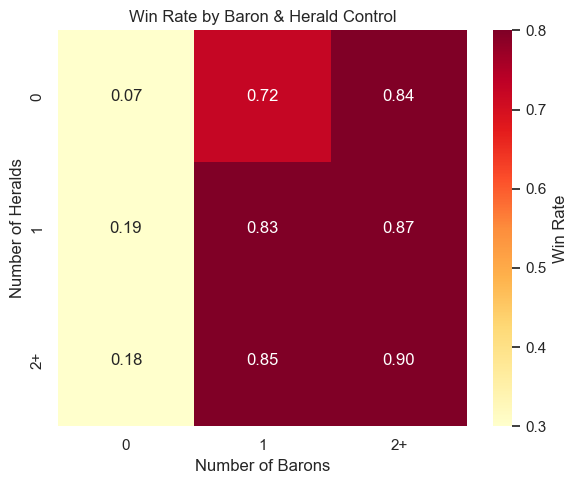

In [14]:
# ===================================================================
# 9) Baron & Herald control vs win rate (2D heatmap)
# ===================================================================
def plot9_baron_herald_control(df, min_games=20):
    """
    2D heatmap of win rate as a function of baron count and herald count.
    """
    df = df.copy()

    def categorize_count(x):
        """Bucket objective counts into 0, 1, 2+."""
        if x <= 0:
            return '0'
        elif x == 1:
            return '1'
        else:
            return '2+'

    df['baron_cat'] = df['barons'].apply(categorize_count)
    df['herald_cat'] = df['heralds'].apply(categorize_count)

    agg = df.groupby(['baron_cat', 'herald_cat'])['result'].agg(['mean', 'count']).reset_index()
    agg = agg[agg['count'] >= min_games]
    if agg.empty:
        print("Not enough data for baron/herald categories.")
        return

    pivot = agg.pivot(index='herald_cat', columns='baron_cat', values='mean')

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',
        vmin=0.3,
        vmax=0.8,
        cbar_kws={'label': 'Win Rate'}
    )
    plt.title('Win Rate by Baron & Herald Control')
    plt.xlabel('Number of Barons')
    plt.ylabel('Number of Heralds')
    plt.tight_layout()
    plt.show()
plot9_baron_herald_control(realtime_df, min_games=20)

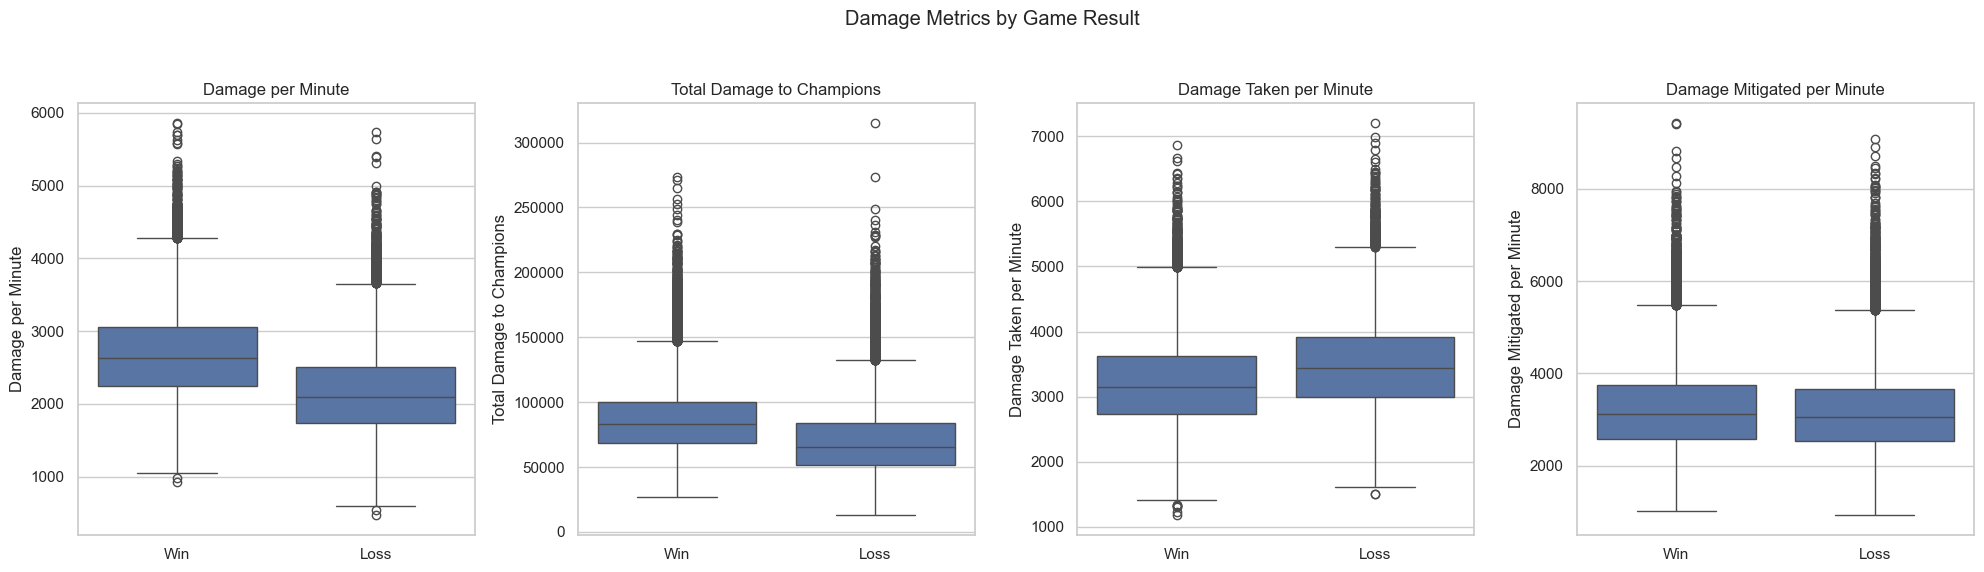

In [15]:
# ===================================================================
# 10) Damage statistics vs win (boxplots)
# ===================================================================
def plot10_damage_vs_win(df):
    """
    Boxplots comparing damage metrics between wins and losses.
    """
    metrics = [
        ('dpm', 'Damage per Minute'),
        ('damagetochampions', 'Total Damage to Champions'),
        ('damagetakenperminute', 'Damage Taken per Minute'),
        ('damagemitigatedperminute', 'Damage Mitigated per Minute')
    ]

    # Create a copy with a readable result label
    tmp = df.copy()
    tmp['result_label'] = tmp['result'].map({0: 'Loss', 1: 'Win'})

    n = len(metrics)
    plt.figure(figsize=(5 * n, 6))

    for i, (col, label) in enumerate(metrics, start=1):
        if col not in tmp.columns:
            continue
        plt.subplot(1, n, i)
        sns.boxplot(data=tmp, x='result_label', y=col)
        plt.title(label)
        plt.xlabel('')
        plt.ylabel(label)

    plt.suptitle('Damage Metrics by Game Result')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot10_damage_vs_win(realtime_df)

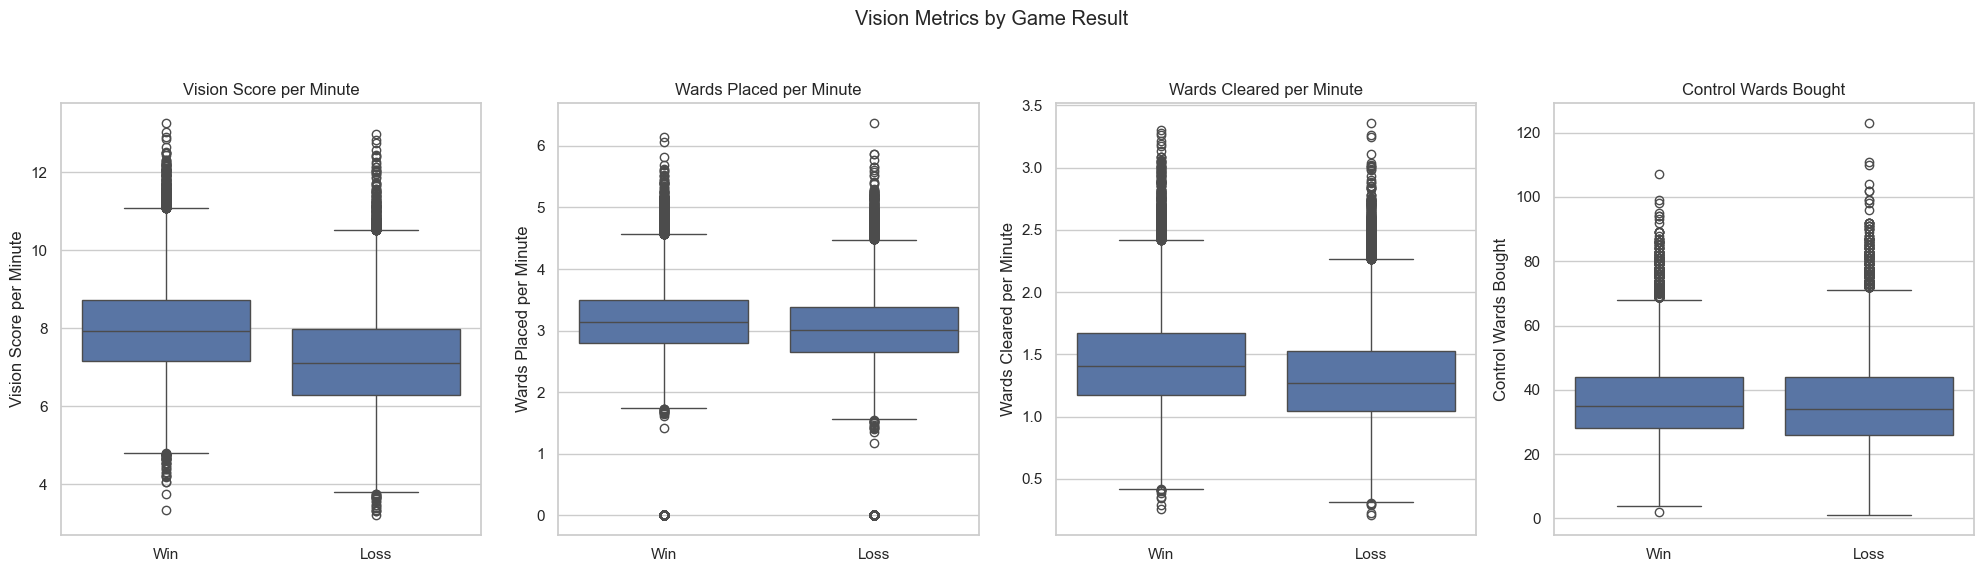

In [16]:
# ===================================================================
# 11) Vision statistics vs win (boxplots)
# ===================================================================
def plot11_vision_vs_win(df):
    """
    Boxplots comparing vision-related stats between wins and losses.
    """
    metrics = [
        ('vspm', 'Vision Score per Minute'),
        ('wpm', 'Wards Placed per Minute'),
        ('wcpm', 'Wards Cleared per Minute'),
        ('controlwardsbought', 'Control Wards Bought')
    ]

    tmp = df.copy()
    tmp['result_label'] = tmp['result'].map({0: 'Loss', 1: 'Win'})

    n = len(metrics)
    plt.figure(figsize=(5 * n, 6))

    for i, (col, label) in enumerate(metrics, start=1):
        if col not in tmp.columns:
            continue
        plt.subplot(1, n, i)
        sns.boxplot(data=tmp, x='result_label', y=col)
        plt.title(label)
        plt.xlabel('')
        plt.ylabel(label)

    plt.suptitle('Vision Metrics by Game Result')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot11_vision_vs_win(realtime_df)

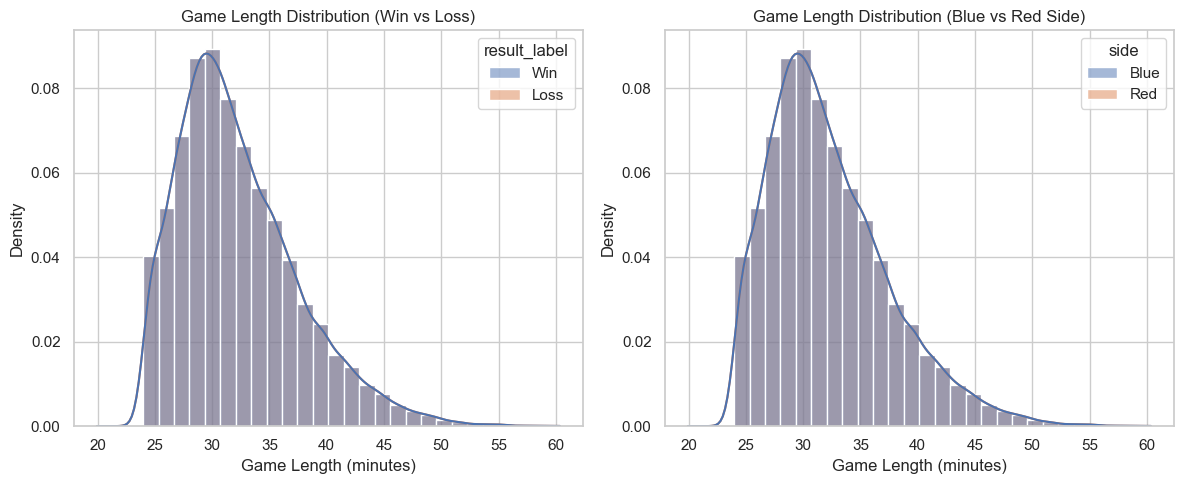

In [17]:
# ===================================================================
# 12) Game length distribution (with win / loss or side)
# ===================================================================
def plot12_game_length_distribution(df):
    """
    Plot the distribution of game length, colored by result and by side.
    """
    # Histogram by result (win vs loss)
    tmp = df.copy()
    tmp['result_label'] = tmp['result'].map({0: 'Loss', 1: 'Win'})

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(
        data=tmp,
        x='gamelength_min',
        hue='result_label',
        bins=30,
        kde=True,
        stat='density',
        common_norm=False
    )
    plt.title('Game Length Distribution (Win vs Loss)')
    plt.xlabel('Game Length (minutes)')
    plt.ylabel('Density')

    # Histogram by side (Blue vs Red)
    plt.subplot(1, 2, 2)
    sns.histplot(
        data=df,
        x='gamelength_min',
        hue='side',
        bins=30,
        kde=True,
        stat='density',
        common_norm=False
    )
    plt.title('Game Length Distribution (Blue vs Red Side)')
    plt.xlabel('Game Length (minutes)')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
plot12_game_length_distribution(realtime_df)